<>:225: SyntaxWarning: invalid escape sequence '\l'
<>:225: SyntaxWarning: invalid escape sequence '\l'
C:\Users\richa\AppData\Local\Temp\ipykernel_46588\2205815653.py:225: SyntaxWarning: invalid escape sequence '\l'
  ax.set_title(f"Cyclic Codes vs $\lambda$, loss_constraint<={tmp0:.3g}")
d:\Anaconda\envs\env-numqi\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


[step=0][time=0.033 seconds] loss=7.2767039486032585
[round=0] min(f)=3.4167672737596687e-16, current(f)=3.4167672737596687e-16
lambda2: 0.1
[step=0][time=0.020 seconds] loss=6.856844692503571
[round=0] min(f)=6.039784163624134e-16, current(f)=6.039784163624134e-16
lambda2: 0.2612244897959184
[step=0][time=0.021 seconds] loss=5.875625097931323
[round=0] min(f)=3.849826906590573e-16, current(f)=3.849826906590573e-16
lambda2: 0.4224489795918368
[step=0][time=0.020 seconds] loss=6.76394968931111
[round=0] min(f)=5.844713684614494e-16, current(f)=5.844713684614494e-16
lambda2: 0.5836734693877551
[step=0][time=0.019 seconds] loss=6.436091886189381
[round=0] min(f)=7.125673812693303e-16, current(f)=7.125673812693303e-16
lambda2: 0.7448979591836735
[step=0][time=0.020 seconds] loss=6.189189774778818
[round=0] min(f)=4.494079469756192e-16, current(f)=4.494079469756192e-16
lambda2: 0.9061224489795919
[step=0][time=0.020 seconds] loss=5.947448423043419
[round=0] min(f)=6.932924692704877e-16, cur

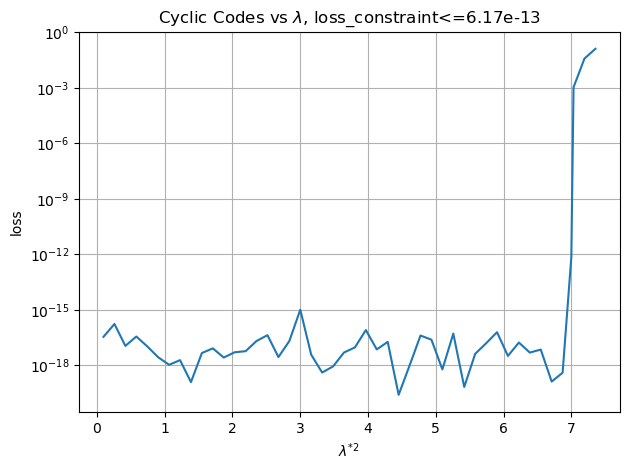

In [1]:
import numpy as np
import torch
import matplotlib.pyplot as plt
from scipy.sparse import csr_matrix, eye
import scipy.sparse as sp
import os
os.environ['MKL_NUM_THREADS'] = '12'
os.environ['OMP_NUM_THREADS'] = '12'
if torch.get_num_threads()!=12:
    torch.set_num_threads(12)
import numqi

sx = np.array([[0.0,1.0],[ 1.0,0.0]])*1j/1j
sy = np.array([[0 ,-1j],[ 1j, 0]])
sz = np.array([[1.0 ,0.0],[ 0.0, -1.0]])*1j/1j
s = np.zeros((4,2,2),dtype=complex)
s[0,:,:] = np.eye(2)
s[1,:,:] = sx
s[2,:,:] = sy
s[3,:,:] = sz

def sigma(i, j, L):
    # i: 1, 2, 3 corresponds to x, y, z
    # i: 0 corresponds to identity
    # j: site index, start from 1

    sig = s
    identity = np.eye(2)
    if j == 1:
        mat = sig[i, :, :]
    else:
        mat = identity*1j/1j
    for k in range(2, L+1):
        if k == j:
            mat = np.kron(mat, sig[i, :, :])
        else:
            mat = np.kron(mat, identity)
    return csr_matrix(mat)

def sigmax(j, L):
    return sigma(1, j, L)

def sigmay(j, L):
    return sigma(2, j, L)

def sigmaz(j, L):
    return sigma(3, j, L)


def computational_basis_to_csr(basis_string):
    """
    Convert a computational basis string to a CSR matrix representation.
    
    Args:
    basis_string (str): A string of '0's and '1's representing the computational basis state.
    
    Returns:
    csr_matrix: The CSR matrix representation of the quantum state.
    """
    # Check if the input string is valid
    if not set(basis_string).issubset({'0', '1'}):
        raise ValueError("Input string must contain only '0's and '1's")
    
    # Calculate the size of the Hilbert space
    n_qubits = len(basis_string)
    hilbert_space_size = 2 ** n_qubits
    
    # Convert the basis string to its decimal representation
    state_index = int(basis_string, 2)
    
    # Create a sparse vector with a single 1 at the correct index
    data = np.array([1.0])
    row_indices = np.array([state_index])
    col_indices = np.array([0])
    
    # Create and return the CSR matrix
    return csr_matrix((data, (row_indices, col_indices)), shape=(hilbert_space_size, 1))

def create_superposition_state(basis_strings, coefficients):
    """
    Create a normalized superposition state from multiple basis states and their coefficients.
    
    Args:
    basis_strings (list of str): List of computational basis strings.
    coefficients (list of float or complex): List of coefficients for each basis state.
    
    Returns:
    csr_matrix: The normalized CSR matrix representation of the superposition state.
    """
    if len(basis_strings) != len(coefficients):
        raise ValueError("Number of basis strings must match number of coefficients")
    
    state = csr_matrix((2**len(basis_strings[0]),1))
    for basis, coeff in zip(basis_strings, coefficients):
        state += coeff * computational_basis_to_csr(basis)
    
    # Normalize the state
    norm = np.linalg.norm(state.data)
    if norm == 0:
        raise ValueError("Cannot normalize a zero state vector")
    state.data /= norm
    
    return state

L=7

np_rng = np.random.default_rng()



Error_set = [sigmaz(0,L)]
Error_set.extend([sigmax(i, L) for i in range(1, L+1)])
Error_set.extend([sigmay(i, L) for i in range(1, L+1)])
Error_set.extend([sigmaz(i, L) for i in range(1, L+1)])

def distance_3_error_set(error_set):
    ret = np.array([])
    len_error_set = len(error_set)
    for i in range(len_error_set):
        for j in range(i+1, len_error_set):
                np.hstack([ret, error_set[i]@error_set[j]])
    return ret

def distance_3_error_set(error_set):
    ret = []
    len_error_set = len(error_set)
    for i in range(len_error_set):
        for j in range(i + 1, len_error_set):
            ret.append(error_set[i] @ error_set[j])
    return ret


class DummyModel(torch.nn.Module):
    def __init__(self, op_list, penalty=1.0):
        super().__init__()
        self.manifold = numqi.manifold.Stiefel(op_list[0].shape[0], 2, dtype=torch.complex128)
        # self.op_list = torch.tensor(op_list, dtype=torch.complex128)
        self.op_list = torch.stack([torch.tensor(op.toarray(), dtype=torch.complex128) for op in op_list])
        self.lambda_target = None
        self.penalty = penalty

    def set_lambda_target(self, x:None|str|float|np.ndarray):
        if x is None:
            self.lambda_target = None
        elif isinstance(x, str):
            assert x in ['min', 'max']
            self.lambda_target = x
        else:
            x = torch.tensor(x, dtype=torch.float64).reshape(-1)
            if x.numel()==1:
                self.lambda_target = x[0]
            else:
                assert x.shape[0]==self.op_list.shape[0]
                self.lambda_target = x

    def forward(self, return_info=False):
        matU = self.manifold()
        lambda_ab_ij = matU.T.conj() @ self.op_list @ matU
        tmp0 = lambda_ab_ij[:,0,1]
        tmp1 = lambda_ab_ij[:,1,0]
        loss_offdiag = torch.vdot(tmp0, tmp0).real + torch.vdot(tmp1, tmp1).real
        tmp0 = lambda_ab_ij[:,0,0].real
        tmp1 = lambda_ab_ij[:,1,1].real
        loss_diag = torch.sum((tmp0-tmp1)**2)
        if self.lambda_target is None:
            loss_lambda = 0
        elif isinstance(self.lambda_target, str) and (self.lambda_target=='min'):
            loss_lambda = torch.dot(tmp0,tmp0)
        elif isinstance(self.lambda_target, str) and (self.lambda_target=='max'):
            loss_lambda = -torch.dot(tmp0,tmp0)
        elif self.lambda_target.numel()==1:
            loss_lambda = (torch.dot(tmp0, tmp0) - self.lambda_target**2)**2
        else:
            tmp0 = tmp0 - self.lambda_target
            loss_lambda = torch.dot(tmp0, tmp0)
        ret = self.penalty*(loss_offdiag + loss_diag) + loss_lambda
        if return_info:
            ret = ret, dict(loss=(ret,loss_offdiag,loss_diag,loss_lambda), lambda_ab_ij=lambda_ab_ij, code=matU)
        return ret



op_list = distance_3_error_set(Error_set)
model = DummyModel(op_list)
model.penalty = 1
lambda2_list = np.linspace(0.1,8,50)#[0.1]#
# Ensure lambda2_list contains 7 if not already present
if 7 not in lambda2_list:
    # Find the right position to insert 7 (between closest values)
    idx = np.searchsorted(lambda2_list, 7)
    lambda2_list = np.insert(lambda2_list, idx, 7)
kwargs = dict(theta0='uniform', num_repeat=10, tol=1e-15, print_freq=0, early_stop_threshold=1e-14)
loss_list = []
threshold = 1e-12
codes =[]
for lambda2_i in lambda2_list:
    model.set_lambda_target(np.sqrt(lambda2_i))
    callback = numqi.optimize.MinimizeCallback(print_freq=500)
    theta_optim = numqi.optimize.minimize(model, callback=callback, **kwargs)
    with torch.no_grad():
        tmp0 = []
        for x in callback.history_state:
            numqi.optimize.set_model_flat_parameter(model, x['optim_x'])
            loss,info = model(return_info=True)
            tmp0.append([x.item() for x in info['loss']])
        print('lambda2:', lambda2_i)
        tmp1 = [(b,c,d) for a,b,c,d in tmp0 if (b<threshold and c<threshold)]
        # print(np.array(sorted(tmp1, key=lambda x: x[2])[:5]))
        loss_list.append(tmp0)
    codes.append(model(return_info=True)[1]['code'])
hf0 = lambda x: (x[1]+x[2]<threshold)
hf1 = lambda x: x[3]
hf2 = lambda x: [np.nan]*4 if (len(x)==0) else min(x, key=hf1)
fval_optim = np.array([hf2([y for y in x if hf0(y)]) for x in loss_list])


fig,ax = plt.subplots()
ax.plot(lambda2_list, fval_optim[:,3])
ax.set_xlabel(r'$\lambda^{*2}$')
ax.set_ylabel('loss')
ax.set_yscale('log')
ax.grid()
# ax.axvline(1, color='red')
tmp0 = np.nan_to_num(fval_optim[1:,1]+fval_optim[1:,2], nan=0).max()
ax.set_title(f"Cyclic Codes vs $\lambda$, loss_constraint<={tmp0:.3g}")
fig.tight_layout()
fig.savefig('tbd01.png', dpi=200)
# fig.savefig('pan_a1a2a3a4a5_rank2NR.png', dpi=200)